In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import tomosipo as ts
from torch import nn
import os
import xraylib
import tifffile
import h5py
import dxchange

import autodiffCT.pipeline as cxpl
import autodiffCT.optimizer as ctxopt
import autodiffCT.operator as ctxoper

from autodiffCT.tomography.reconstruction import PyTorchFbpOperator, fbp
from autodiffCT.tomography.phase import PaganinPhaseRetrievalOperator, PhaseContrastOperator
from autodiffCT.operator.utils import ClearPyTorchGpuCacheOperator
from autodiffCT.image.segmentation import ThresholdOperator
from autodiffCT.operator.graph import MatchScalingOperator, VoidOperator


from autodiffCT.tomography.phase import retrieve_phase

import tomopy

    
def plot_imgs(height=5, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    fig.patch.set_alpha(1.0)
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        if isinstance(v, torch.Tensor):
            v = v.cpu().numpy()
        pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()
    plt.show()


def get_dx_dims(fname, dataset):
    grp = '/'.join(['exchange', dataset])                                                 
    with h5py.File(fname, "r") as f:                                                      
        try:                                                                              
            data = f[grp]                                                                 
        except KeyError:                                                                  
            return None                                                                   
        shape = data.shape                                                                
    return shape


def tomopy_fuelcell_get_projs(h5fname, sino, nframes, frame, nproj, binning, phase):
    # Read APS 32-BM raw data.                                                                                                                             
    proj, flat, dark, theta = dxchange.read_aps_32id(h5fname, sino=sino)
                                                                                                                                                           
    if int(frame-nframes)>0:                                                              
        proj = proj[(frame-nframes/2)*nproj:(frame+nframes/2)*nproj,:,:]                  
                                                                                          
    # Flat-field correction of raw data.                                                                                                    
    data = tomopy.normalize(proj, flat, dark, cutoff=1.4)
    
    sample_detector_distance = 25                                                         
    detector_pixel_size_x = 3.0e-4                                                        
    monochromator_energy = 16                                                             
                                                                                          
    # phase retrieval
    if phase:
        data = tomopy.prep.phase.retrieve_phase(data,
                                                pixel_size=detector_pixel_size_x,
                                                dist=sample_detector_distance,
                                                energy=monochromator_energy,
                                                alpha=8e-03,
                                                pad=True)                                              
                                                                                          
    # Binning                                                                             
    data = tomopy.downsample(data, level=binning, axis=2)                                 
    if data.shape[1]>1:                                                                   
        data = tomopy.downsample(data, level=binning, axis=1)
    return data

/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
astropy module not found
olefile module not found


# Load tomobank data

We load the tomobank data supplied from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html (downloaded 7 june 2022). We use the file called 'fuelcell_dryHQ_i1.h5'.

In [3]:
# Get date to date the saves:
from datetime import datetime
import os

date_str = datetime.today().strftime('0%Y-%m-%d')
path = 'experimental_results/'+date_str +'/'

# Meceake directory if it does not exist
folder = os.path.dirname(path)
if not os.path.exists(folder):
    os.makedirs(folder)

In [4]:
np.set_printoptions(precision=8)
torch.set_printoptions(precision=8)

###  LOAD TOMOBANK DATA  ###
h5fname = 'PATH TO YOUR fuelcell file here/fuelcell_dryHQ_i1.h5'

downsample = 0 # Will be 2^binning
data_size = get_dx_dims(h5fname, 'data')
sinoshape = (0, data_size[1])
rot_center = 702.0 / 2**downsample
proj, flat, dark, theta = dxchange.read_aps_32id(h5fname, sino=sinoshape)
del proj
del flat,
del dark

phase_contrast_numpy = tomopy_fuelcell_get_projs(h5fname, sinoshape, nframes=1, frame=0, nproj=1001, binning=downsample, phase=False)
phase_contrast_ims = torch.tensor(phase_contrast_numpy, requires_grad=False)
torch.save(phase_contrast_ims, path + 'fuelcell_phase_contrast_ims.torch')
del phase_contrast_numpy

torch.Size([1001, 1100, 1440])
[702. 702. 702. ... 702. 702. 702.]
Rotation center is off by -18 pixels
torch.Size([1001, 160, 1476])


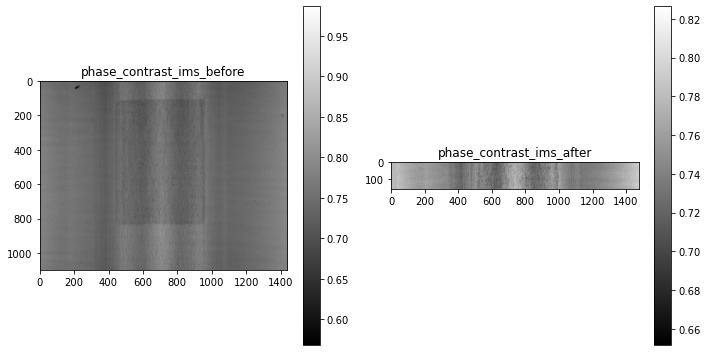

In [6]:
rot_offset_pix = round(rot_center - phase_contrast_ims.shape[2]/2.0)
print("Rotation center is off by", rot_offset_pix, "pixels")

padding = torch.zeros(size=(1001, 1100//2**downsample, 2*abs(rot_offset_pix)), requires_grad=False)
padding[:] = phase_contrast_ims[:,:,0].mean()

# The image is too large to fit into memory. For optimization, we truncate the volume.
truncate = 470
step = 1

if rot_offset_pix > 0:
    aligned_phase_maps = torch.cat([phase_contrast_ims, padding], dim=2)[::step,truncate:-truncate,:]
elif rot_offset_pix < 0:
    aligned_phase_maps = torch.cat([padding, phase_contrast_ims], dim=2)[::step,truncate:-truncate,:]
del padding
theta = theta[::step]

plot_imgs(phase_contrast_ims_before=phase_contrast_ims[500//step], phase_contrast_ims_after=aligned_phase_maps[500//step])
del phase_contrast_ims
aligned_phase_maps.requires_grad = True

In [7]:
# Create tomosipo geometries
vsize1 = aligned_phase_maps.shape[1]
vsize2 = aligned_phase_maps.shape[2]

vg = ts.volume(shape=(vsize1, vsize2, vsize2))
pg_par = ts.parallel(angles=theta, shape=(vsize1, vsize2), size=(vsize1, vsize2))
A_par = ts.operator(vg, pg_par)

# Unsupervised fit of beta and delta

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    raise Exception("No GPU available")
device = 'cpu'

aligned_phase_maps = aligned_phase_maps.to(device)

# The params specified in the Tomobank database:
propg_dist = 25.0
det_pix_size = 3.0e-4
beam_energy = 16.0

# Unknown parameters, starting with water values:
compound =  "H2O"
density = 1.0 #g/cm3
delta = 1.0 - xraylib.Refractive_Index_Re(E=beam_energy, compound=compound, density=density)
print("Xraylib refraction:", delta)
# Real beta
beta = xraylib.Refractive_Index_Im(E=beam_energy, compound=compound, density=density)
print("Xraylib beta:", beta)

delta = np.log(delta)
beta = np.log(beta)
print("Alpha (log):", delta/beta)

Xraylib refraction: 9.012268427088799e-07
Xraylib beta: 8.679286233554469e-10
Beta: -20.864911635806685 delta: -13.919508843313837
Alpha: 0.6671252237381295


In [10]:
class Logger:
    def __init__(self):
        self.betas = []
        self.deltas = []
        self.prop_dists = []
        self.pix_sizes = []
        self.beam_ens = []
    
    def log(self, optimizer_object):
        b = optimizer_object.pipeline.operators[1].parameters['log_beta']
        d = optimizer_object.pipeline.operators[1].parameters['log_delta']
        pr = optimizer_object.pipeline.operators[1].parameters['propg_dist']
        pi = optimizer_object.pipeline.operators[1].parameters['pixel_size']
        be = optimizer_object.pipeline.operators[1].parameters['beam_energy']
        self.betas.append(b.value.detach().clone().cpu())
        self.deltas.append(d.value.detach().clone().cpu())
        self.prop_dists.append(pr.value.detach().clone().cpu())
        self.pix_sizes.append(pi.value.detach().clone().cpu())
        self.beam_ens.append(be.value.detach().clone().cpu())

In [11]:
if not isinstance(beta, torch.Tensor):
    beta = torch.tensor(beta, requires_grad=True, device=device)
if not isinstance(delta, torch.Tensor):
    delta = torch.tensor(delta, requires_grad=True, device=device)
if not isinstance(propg_dist, torch.Tensor):
    propg_dist = torch.tensor(propg_dist, requires_grad=True, device=device)
if not isinstance(det_pix_size, torch.Tensor):
    det_pix_size = torch.tensor(det_pix_size, requires_grad=True, device=device)
if not isinstance(beam_energy, torch.Tensor):
    beam_energy = torch.tensor(beam_energy, requires_grad=True, device=device)


phase_retrieval_op = PaganinPhaseRetrievalOperator(A_par,
                                                   device=device,
                                                   log_beta=beta,
                                                   log_delta=delta,
                                                   propg_dist_cm=propg_dist,
                                                   pixel_size_cm=det_pix_size,
                                                   beam_energy=beam_energy)

fbp_op = PyTorchFbpOperator(A_par, device=device)

target_proj = aligned_phase_maps.clone()
target_proj = target_proj.unsqueeze(0).to(device)

dataset = torch.utils.data.TensorDataset(aligned_phase_maps.unsqueeze(0), target_proj)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

gpu_save_op = ClearPyTorchGpuCacheOperator()#-750Mb
gpu_save_op2 = ClearPyTorchGpuCacheOperator()
gpu_save_op3 = ClearPyTorchGpuCacheOperator()

thr_op = ThresholdOperator(bins=256, device='cpu', n_classes=2, split_classes=False,
                           gamma=100.0, re_init_at_call=True)

# Initialize with Otsu
with torch.no_grad():
    thr_op.initialize_threshold(aligned_phase_maps)

phase_proj_op = PhaseContrastOperator(projector=A_par,
                                log_beta=phase_retrieval_op.parameters['log_beta'],
                                log_delta=phase_retrieval_op.parameters['log_delta'],
                                propg_dist_cm=phase_retrieval_op.parameters['propg_dist'],
                                pixel_size_cm=phase_retrieval_op.parameters['pixel_size'],
                                beam_energy=phase_retrieval_op.parameters['beam_energy'],
                                device=device)

# For reference:
phase_retrieval_op2 = PaganinPhaseRetrievalOperator(A_par,
                                                   device=device,
                                                   log_beta=torch.tensor(beta.cpu().numpy().copy()),
                                                   log_delta=torch.tensor(delta.cpu().numpy().copy()),
                                                   propg_dist_cm=torch.tensor(propg_dist.cpu().numpy().copy()),
                                                   pixel_size_cm=torch.tensor(det_pix_size.cpu().numpy().copy()),
                                                   beam_energy=torch.tensor(beam_energy.cpu().numpy().copy()))

In [12]:
source_op = VoidOperator()
match_scaling_op = MatchScalingOperator()

pipeline = cxpl.GraphPipeline([
    (source_op, [phase_retrieval_op, match_scaling_op]),
    (phase_retrieval_op, [fbp_op]),
    (fbp_op, [gpu_save_op]),
    (gpu_save_op, [thr_op]),
    (thr_op, [phase_proj_op]),
    (phase_proj_op, [gpu_save_op3]),
    (gpu_save_op3, [match_scaling_op]),
    (match_scaling_op, [])
    ]
)

In [13]:
# Define optimizer with separate learning rate:
lr = 1e-30

param_dict = {
    phase_retrieval_op: {
        'propg_dist' : 1e-30,
        'beam_energy' : 1e-30,
        'log_beta' : 1e0,
        'log_delta' : 1e0,
        'pixel_size' : 1e-30
    }
}
    
logger = Logger()
optimizer = ctxopt.PyTorchAdam(pipeline,
            target_parameters=param_dict,
            learning_rate=lr)

In [14]:
# Optimize
niter = 200

optimal_params = optimizer.optimize(torch.nn.functional.mse_loss,
                                    data_loader=data_loader,
                                    n_iterations=niter,
                                    callback=logger.log,
                                    save_gpu_memory=True)#Saves 1.2Gb

  0%|          | 0/200 [00:00<?, ?it/s]/export/scratch2/schoonho/anaconda3/envs/pipeline_python310/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 200/200 [1:38:07<00:00, 29.44s/it]


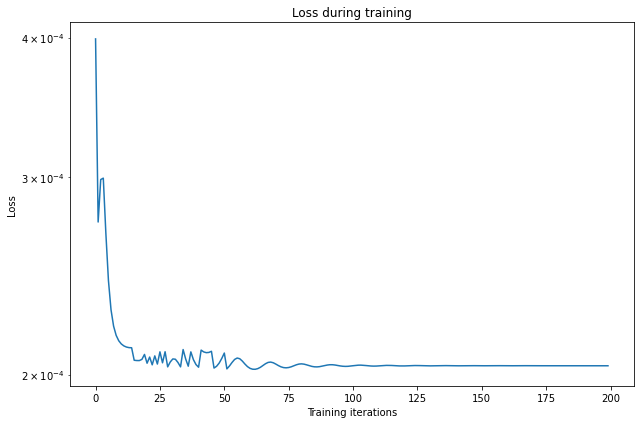

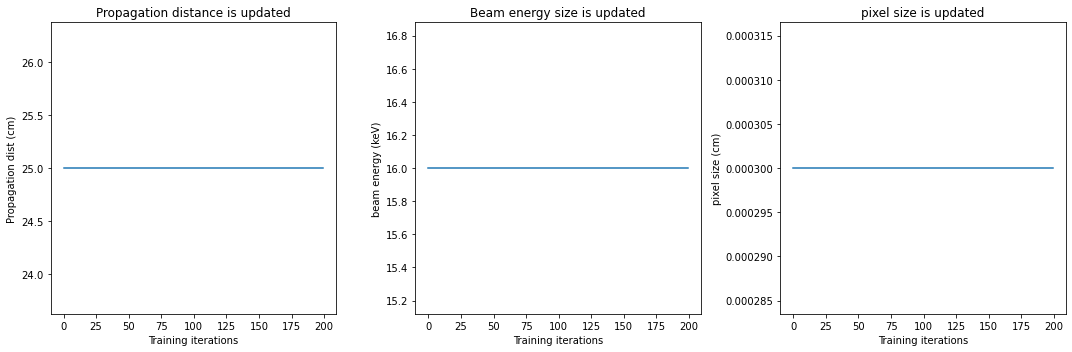

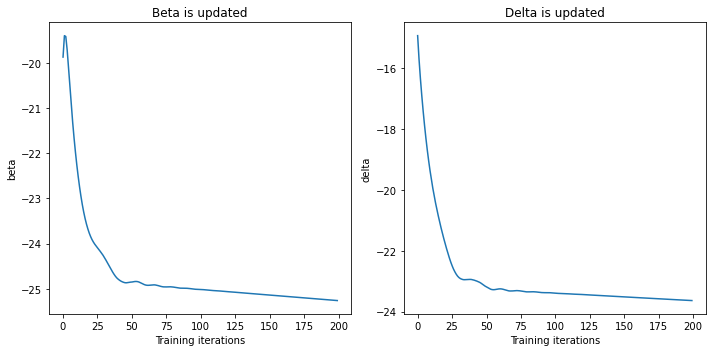

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))
ax1.set_title("Loss during training")
ax1.plot(optimizer.losses)
ax1.set_yscale('log')
ax1.set_xlabel("Training iterations")
ax1.set_ylabel("Loss")

fig.tight_layout()

torch.save(torch.tensor(optimizer.losses), path + "fuelcell_phase_losses.torch")

fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(15, 5))
ax2.plot(logger.prop_dists)
ax2.set_title("Propagation distance is updated")
ax2.set_xlabel("Training iterations")
ax2.set_ylabel("Propagation dist (cm)")

ax3.plot(logger.beam_ens)
ax3.set_title("Beam energy size is updated")
ax3.set_xlabel("Training iterations")
ax3.set_ylabel("beam energy (keV)")

ax4.plot(logger.pix_sizes)
ax4.set_title("pixel size is updated")
ax4.set_xlabel("Training iterations")
ax4.set_ylabel("pixel size (cm)")

fig.tight_layout()

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(10, 5))
ax5.plot(logger.betas)
ax5.set_title("Beta is updated")
ax5.set_xlabel("Training iterations")
ax5.set_ylabel("beta")

ax6.plot(logger.deltas)
ax6.set_title("Delta is updated")
ax6.set_xlabel("Training iterations")
ax6.set_ylabel("delta")

fig.tight_layout()
plt.show()

torch.save(torch.tensor(logger.betas), path + "fuelcell_betas.torch")
torch.save(torch.tensor(logger.deltas), path + "fuelcell_deltas.torch")

In [16]:
with torch.no_grad():
    aligned_phase_maps = aligned_phase_maps.detach()
    phase_maps = phase_retrieval_op(aligned_phase_maps)
    fbp_rec = fbp_op(phase_maps.unsqueeze(0))
    segm = thr_op(fbp_rec.squeeze(0))
    proj_segm = phase_proj_op(segm.unsqueeze(0))
    out = match_scaling_op(torch.stack([aligned_phase_maps.unsqueeze(0), proj_segm], dim=0))

    print("Final pipeline loss:", torch.nn.functional.mse_loss(out, target_proj).item())

    #Compare to original
    phase_proj_op2 = PhaseContrastOperator(projector=A_par,
                                    log_beta=phase_retrieval_op2.parameters['log_beta'],
                                    log_delta=phase_retrieval_op2.parameters['log_delta'],
                                    propg_dist_cm=phase_retrieval_op2.parameters['propg_dist'],
                                    pixel_size_cm=phase_retrieval_op2.parameters['pixel_size'],
                                    beam_energy=phase_retrieval_op2.parameters['beam_energy'],
                                    device=device)
    phase_maps2 = phase_retrieval_op2(aligned_phase_maps)
    fbp_rec2 = fbp_op(phase_maps2.unsqueeze(0)).squeeze(0)
    segm2 = thr_op(fbp_rec2)
    proj_segm2 = phase_proj_op2(segm2.unsqueeze(0))
    out2 = match_scaling_op(torch.stack([aligned_phase_maps.unsqueeze(0), proj_segm2], dim=0)).squeeze(0)

    print("Original pipeline loss:", torch.nn.functional.mse_loss(out2, target_proj).item())

Final pipeline loss: 0.00020365143427625299
Original pipeline loss: 0.000398948643123731


/tmp/ipykernel_819288/3495802385.py:34: UserWarning: Using a target size (torch.Size([1, 1001, 160, 1476])) that is different to the input size (torch.Size([1001, 160, 1476])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print("Original pipeline loss:", torch.nn.functional.mse_loss(out2, target_proj).item())


In [21]:
print(logger.betas[-1], logger.deltas[-1])
torch.save(phase_maps.cpu().detach(), path + 'fuelcell_final_phase_maps.torch')
torch.save(phase_maps2.cpu().detach(), path + 'fuelcell_start_phase_maps.torch')
torch.save(fbp_rec.cpu().detach(), path + 'fuelcell_final_fbp.torch')
torch.save(fbp_rec2.cpu().detach(), path + 'fuelcell_start_fbp.torch')
torch.save(fbp_rec[0,80,600//2**downsample:800//2**downsample,800//2**downsample:1000//2**downsample].cpu().detach(), path+'fuelcell_final_zoom_fbp.torch')
torch.save(fbp_rec2[80,600//2**downsample:800//2**downsample,800//2**downsample:1000//2**downsample].cpu().detach(), path+'fuelcell_start_zoom_fbp.torch')

tensor(-25.26273466, dtype=torch.float64) tensor(-23.63456329, dtype=torch.float64)


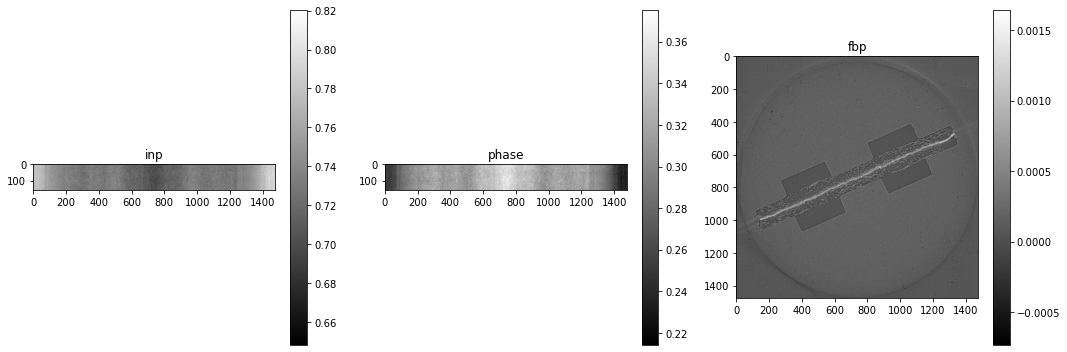

In [19]:
plot_imgs(inp=aligned_phase_maps[80], phase=phase_maps[:,80],fbp=fbp_rec[0,80])

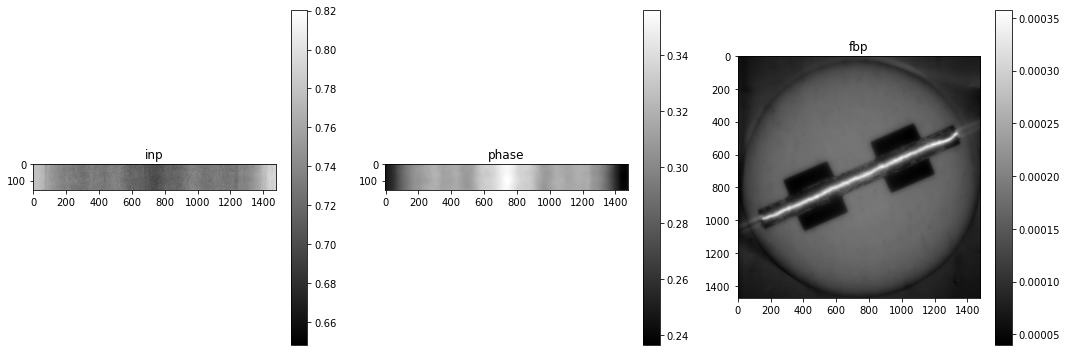

In [18]:
plot_imgs(inp=aligned_phase_maps[80], phase=phase_maps2[:,80], fbp=fbp_rec2[80])

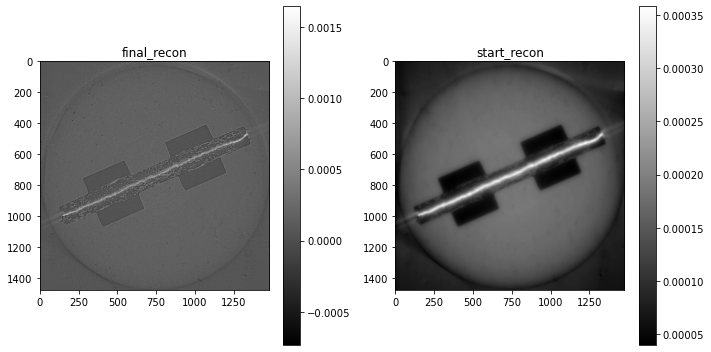

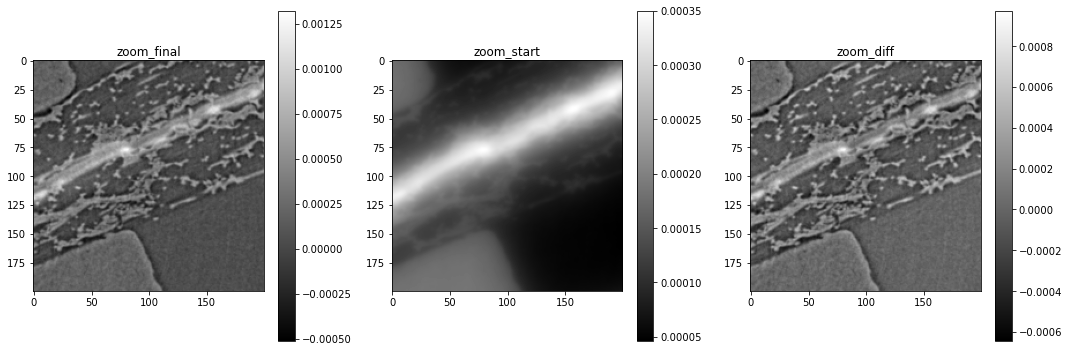

In [20]:
plot_imgs(final_recon=fbp_rec[0,80].cpu().detach(),
          start_recon=fbp_rec2[80].cpu().detach())
plot_imgs(zoom_final=fbp_rec[0,80,600//2**downsample:800//2**downsample,800//2**downsample:1000//2**downsample].cpu().detach(),
          zoom_start=fbp_rec2[80,600//2**downsample:800//2**downsample,800//2**downsample:1000//2**downsample].cpu().detach(),
          zoom_diff=(fbp_rec-fbp_rec2)[0,80,600//2**downsample:800//2**downsample,800//2**downsample:1000//2**downsample].cpu().detach())

In [22]:
# Save pipeline
pipeline.save(path + "phase_fuelcell_pipeline_" + date_str + ".pickle")
optimizer.save(path + "phase_fuelcell_optimizer_" + date_str + ".pickle")

In [23]:
# Save all the tensors
torch.save(phase_maps, path + 'phase_maps.torch')
torch.save(phase_maps2, path + 'phase_maps2.torch')
torch.save(fbp_rec, path + 'fbp_rec.torch')
torch.save(fbp_rec2, path + 'fbp_rec2.torch')
torch.save(segm, path + 'segm.torch')
torch.save(segm2, path + 'segm2.torch')
torch.save(proj_segm, path + 'proj_segm.torch')
torch.save(proj_segm2, path + 'proj_segm2.torch')
torch.save(out, path + 'out.torch')
torch.save(out2, path + 'out2.torch')